In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from pandas.tseries.offsets import *

### Data Preprocessing

In [ ]:
directory = 'source/topBonds.csv'

# read sql
df = pd.read_csv(directory, parse_dates=['TrdExctnDtEOM'])

# select columns
df = df[['CusipId', 'TrdExctnDtEOM', 'Volume', 'Coupon', 'RatingClass', 'MaturityBand', 'R']]

# rename columns
df.columns = ['Cusip', 'Date', 'Volume', 'Coupon', 'RatingClass', 'MaturityBand', 'R']

# sort values to CusipId-Date
df = df.sort_values(by=['Cusip', 'Date'])

### Quantile Filtering and Outlier Visualization

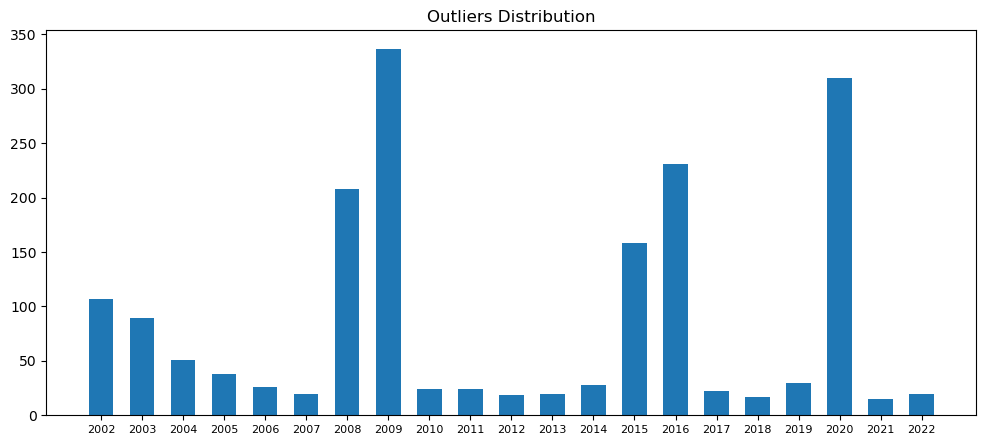

In [3]:
# identify values > 99.5th and < 0.05th percentiles
df['quantiles'] = pd.qcut(df.R, np.linspace(0, 1, 201), labels=np.linspace(0, 1, 200)).astype(float)

# mark them as outliers
df['outliers'] = np.where((df['quantiles'] > 0.995) | (df['quantiles'] < 0.005), 1, 0)

# visualize outliers per year
df['Year'] = df['Date'].dt.year
df_g = df.groupby('Year')['outliers'].sum().reset_index()
plt.figure(figsize=(12, 5))
plt.title('Outliers Distribution')
plt.bar(df_g['Year'], df_g['outliers'], width = 0.6)
plt.xticks([i for i in range(2002, 2023)], fontsize=8)
plt.show()

In [4]:
# this filter requires for the bond to be present in the full duration of the formation period
df['R'] = np.where(df['outliers'] == 0, df['R'], np.nan)

### Exploratory Analysis

In [5]:
df['Cusip'].nunique()

18673

In [6]:
# number of entries
df['RatingClass'].value_counts()

IG    251441
HY    105727
Name: RatingClass, dtype: int64

In [7]:
# number of distinct Cusips
df.groupby('RatingClass').Cusip.nunique()

RatingClass
HY     4797
IG    15566
Name: Cusip, dtype: int64

In [8]:
# number of entries
df['MaturityBand'].value_counts()

2.0    271390
3.0     72007
1.0     13653
Name: MaturityBand, dtype: int64

In [9]:
# number of distinct Cusips
df.groupby('MaturityBand').Cusip.nunique()

MaturityBand
1.0     1604
2.0    13555
3.0     3500
Name: Cusip, dtype: int64

In [10]:
print('Number of observations: {:,}'.format(len(df.index)))
print('Returns: Mean: {:.5f} | Median: {:.5f} | Std returns: {:.5f}'.format(
    100 * df['R'].mean(), 100 * df['R'].median(), df['R'].std()))
print('Volume Mean: {:.5f}'.format(df['Volume'].mean()))
print('Coupon Mean: {:.5f}'.format(df['Coupon'].mean()))

Number of observations: 1,050,018
Returns: Mean: 0.02615 | Median: -0.03103 | Std returns: 0.03180
Volume Mean: 6895765.77606
Coupon Mean: 5.46051


### Portfolio Analysis

In [11]:
# log returns
df['LogR'] = np.log(1 + df['R'])

# formation period in months
J = 2 

# sort on Cusip, Date
df_ = df[['Cusip', 'Date', 'R', 'LogR']].sort_values(['Cusip', 'Date']).set_index('Date')

# cumulative sum of returns given the formation period
cumulative_r = df_.groupby(['Cusip'])['LogR'].rolling(J, min_periods=J).sum().reset_index()
cumulative_r = cumulative_r.rename(columns = {'LogR': 'SumLogR'})
cumulative_r['CumReturns'] = np.exp(cumulative_r['SumLogR'])-1

# momentum ranking
r = 10 
cumulative_r = cumulative_r.dropna(axis=0, subset=['CumReturns'])
cumulative_r['MomentumRanking'] = cumulative_r.groupby('Date')['CumReturns'].transform(lambda x: pd.qcut(x, r, labels=False))
cumulative_r['MomentumRanking'] = 1 + cumulative_r['MomentumRanking'].astype(int)

# mean of cumulative returns for the momentum ranking
cumulative_r.groupby('MomentumRanking')['CumReturns'].mean()

MomentumRanking
1    -0.058112
2    -0.024646
3    -0.015058
4    -0.008629
5    -0.003138
6     0.002346
7     0.008263
8     0.015505
9     0.026671
10    0.063543
Name: CumReturns, dtype: float64

In [12]:
# holding period in months
K = 5 
cumulative_r['FormationDate'] = cumulative_r['Date']

# holding period date ranges
cumulative_r['HoldingDate1'], cumulative_r['HoldingDate2'] = cumulative_r['Date'] + MonthBegin(1), cumulative_r['Date'] + MonthEnd(K)
cumulative_r = cumulative_r[['Cusip', 'FormationDate', 'MomentumRanking', 'HoldingDate1', 'HoldingDate2']]

# join momentum ranking and returns
portfolios = pd.merge(df[['Cusip', 'Date', 'R']], cumulative_r, on=['Cusip'], how='inner')
portfolios = portfolios[(portfolios['HoldingDate1'] <= portfolios['Date']) & (portfolios['Date'] <= portfolios['HoldingDate2'])]
portfolios = portfolios[['Cusip', 'FormationDate', 'MomentumRanking', 'HoldingDate1', 'HoldingDate2', 'Date', 'R']]

agg_portfolios = portfolios.groupby(['Date', 'MomentumRanking', 'FormationDate'])['R'].mean().reset_index()

# skip first two years
agg_portfolios = agg_portfolios.loc[agg_portfolios.Date.dt.year >= agg_portfolios['Date'].dt.year.min() + 2]
agg_portfolios = agg_portfolios.sort_values(by=['Date', 'MomentumRanking'])

# calculate mean and std on returns
eq_weighted_return = agg_portfolios.groupby(['Date', 'MomentumRanking'])['R'].mean().reset_index()
eq_weighted_std = agg_portfolios.groupby(['Date', 'MomentumRanking'])['R'].std().reset_index()

# rename columns
eq_weighted_return = eq_weighted_return.rename(columns={'R': 'EqualWeightedReturn'})
eq_weighted_std = eq_weighted_std.rename(columns={'R': 'EqualWeightedStd'})

# unify equal weighted return metrics
eq_weighted_return_df = pd.merge(eq_weighted_return, eq_weighted_std, on=['Date', 'MomentumRanking'], how='inner')
eq_weighted_return_df = eq_weighted_return_df.sort_values(by=['MomentumRanking', 'Date'])

# portfolio summary
eq_weighted_return_df.groupby(['MomentumRanking'])['EqualWeightedReturn'].describe()[['count','mean', 'std']].reset_index()

,MomentumRanking,count,mean,std
0,1,225.0,-0.001105,0.029829
1,2,225.0,-0.001120,0.021709
2,3,225.0,-0.001074,0.018377
3,4,225.0,-0.001027,0.016426
4,5,225.0,-0.000733,0.017198
5,6,225.0,-0.000458,0.016384
6,7,225.0,-0.000707,0.016118
7,8,225.0,-0.000390,0.016359
8,9,225.0,-0.000229,0.018313
9,10,225.0,0.001467,0.022624


In [13]:
# transpose equal weighted returns
eq_weighted_return_tdf = eq_weighted_return_df.pivot(index='Date', columns='MomentumRanking', values='EqualWeightedReturn') 

# modify portfolio naming
eq_weighted_return_tdf = eq_weighted_return_tdf.add_prefix('Portfolio-') 

# identify losers and winners
eq_weighted_return_tdf = eq_weighted_return_tdf.rename(columns={'Portfolio-1': 'Losers', 'Portfolio-10': 'Winners'})

# calculate long-short strategy
eq_weighted_return_tdf['LongShort'] = eq_weighted_return_tdf.Winners - eq_weighted_return_tdf.Losers

# portfolio summary
eq_weighted_return_tdf.head()

MomentumRanking,Losers,Portfolio-2,Portfolio-3,Portfolio-4,Portfolio-5,Portfolio-6,Portfolio-7,Portfolio-8,Portfolio-9,Winners,LongShort
Date,,,,,,,,,,,
2004-01-31,0.009542,0.002167,0.005851,0.003164,0.005908,0.001598,0.003952,0.001669,0.001061,0.010066,0.000524
2004-02-29,0.005478,0.000861,0.004573,0.010994,0.006325,0.008560,0.003385,0.002379,-0.007032,-0.018424,-0.023903
2004-03-31,0.006860,0.001516,0.002836,0.003193,0.003971,0.008210,0.003373,-0.001484,0.002092,0.002197,-0.004663
2004-04-30,-0.013814,-0.018073,-0.022339,-0.024797,-0.028378,-0.033606,-0.036492,-0.021401,-0.028313,-0.015038,-0.001225
2004-05-31,-0.024222,-0.018377,-0.011507,-0.012756,-0.013691,-0.014144,-0.009544,-0.018222,-0.019407,-0.012314,0.011908


In [14]:
# compute cumulative returns
eq_weighted_return_tdf['CumulativeReturns_Winners'] = (1 + eq_weighted_return_tdf.Winners).cumprod() - 1 
eq_weighted_return_tdf['CumulativeReturns_Losers'] = (1 + eq_weighted_return_tdf.Losers).cumprod() - 1
eq_weighted_return_tdf['CumulativeReturns_LongShort'] = (1 + eq_weighted_return_tdf.LongShort).cumprod() - 1

momentum_mean = eq_weighted_return_tdf[['Winners', 'Losers', 'LongShort']].mean().to_frame()
momentum_mean = momentum_mean.rename(columns={0: 'mean'}).reset_index()
momentum_mean

,MomentumRanking,mean
0,Winners,0.001467
1,Losers,-0.001105
2,LongShort,0.002572


In [15]:
# t-statistics for winners, losers, long-short
t_losers = pd.Series(stats.ttest_1samp(eq_weighted_return_tdf['Losers'], 0.0)).to_frame().T 
t_winners = pd.Series(stats.ttest_1samp(eq_weighted_return_tdf['Winners'], 0.0)).to_frame().T 
t_long_short = pd.Series(stats.ttest_1samp(eq_weighted_return_tdf['LongShort'], 0.0)).to_frame().T

# build structures
t_losers['MomentumRanking'] = 'Losers'
t_winners['MomentumRanking'] = 'Winners'
t_long_short['MomentumRanking'] = 'LongShort'

# combine statistics
t_output = pd.concat([t_winners, t_losers, t_long_short]).rename(columns={0: 't-stat', 1: 'p-value'}) 
momentum_output = pd.merge(momentum_mean, t_output, on=['MomentumRanking'], how='inner')

# format output
momentum_output['mean'] = momentum_output['mean'].map('{:.2%}'.format) 
momentum_output['t-stat'] = momentum_output['t-stat'].map('{:.2f}'.format) 
momentum_output['p-value'] = momentum_output['p-value'].map('{:.2f}'.format) 
print('Momentum Strategy Summary:\n\n', momentum_output)

Momentum Strategy Summary:

   MomentumRanking    mean t-stat p-value
0         Winners   0.15%   0.97    0.33
1          Losers  -0.11%  -0.56    0.58
2       LongShort   0.26%   2.17    0.03


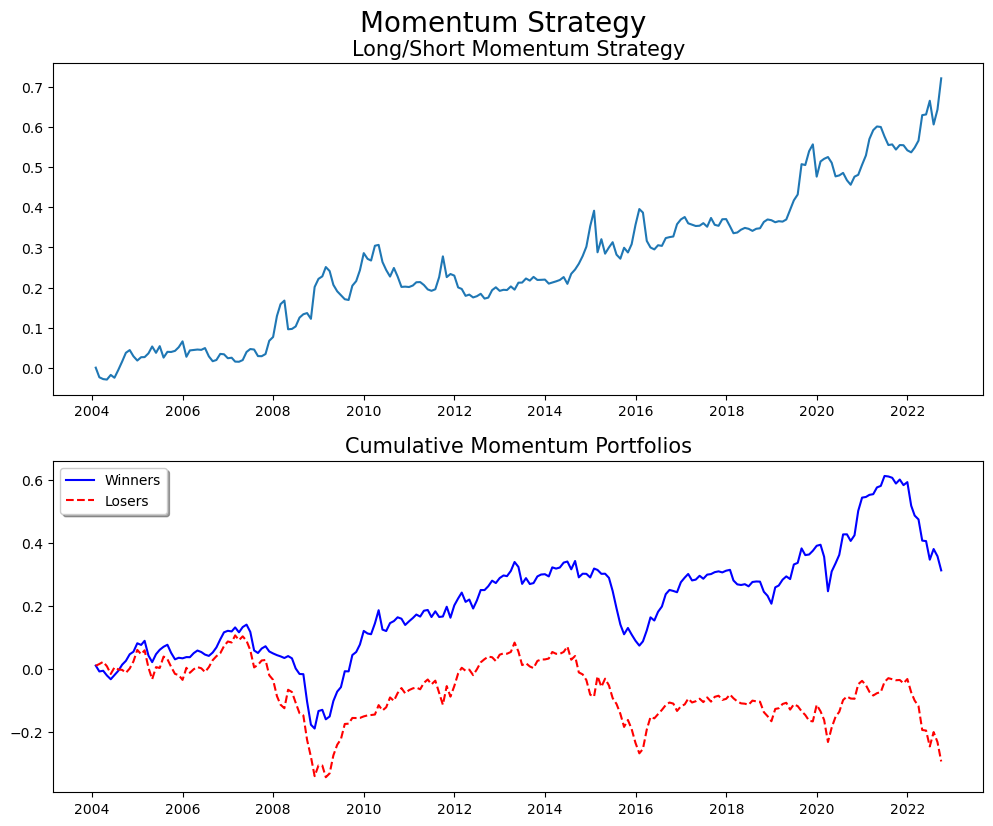

In [16]:
# visualization of cumulative strategy, winners, losers
plt.figure(figsize=(12,9)) 
plt.suptitle('Momentum Strategy', fontsize=20) 
ax1 = plt.subplot(211) 
ax1.set_title('Long/Short Momentum Strategy', fontsize=15) 
ax1.plot(eq_weighted_return_tdf['CumulativeReturns_LongShort']) 
ax2 = plt.subplot(212) 
ax2.set_title('Cumulative Momentum Portfolios', fontsize=15) 
ax2.plot(eq_weighted_return_tdf['CumulativeReturns_Winners'], 'b-', eq_weighted_return_tdf['CumulativeReturns_Losers'], 'r--') 
ax2.legend(('Winners','Losers'), loc='upper left', shadow=True)
plt.subplots_adjust(top=0.92, hspace=0.2)